In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
                        

In [ ]:
N = 1000
series = np.sin(0.1*np.arange(N))
series_noise = series + np.random.randn(N) * 0.1

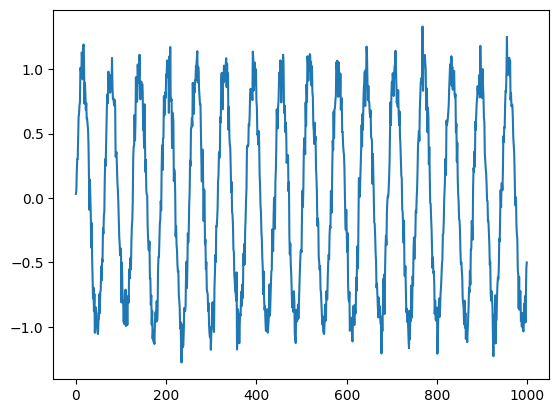

In [3]:
plt.plot(series_noise)
plt.show()

In [95]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series_noise[t:t+T]
  X.append(x)
  y = series_noise[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [18]:
X.shape, Y.shape

((990, 10, 1), (990, 1))

In [22]:
N = len(X)
print("X shape", X.shape, "Y shape", Y.shape)

X shape (990, 10, 1) Y shape (990, 1)


In [78]:


# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)




cpu


In [79]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out



In [96]:


# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [97]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))


In [98]:


# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)



In [99]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test, 
            epochs=1000):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()

        train_losses[it] = loss.item()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        print(f"Epoch {it}/{epochs} train loss: {train_losses[it]} test_losses: {test_loss}")
    return train_losses, test_losses

In [100]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 0/1000 train loss: 0.5386672616004944 test_losses: 0.5197134017944336
Epoch 1/1000 train loss: 0.5351452827453613 test_losses: 0.5162925720214844
Epoch 2/1000 train loss: 0.5316275954246521 test_losses: 0.5128807425498962
Epoch 3/1000 train loss: 0.5281117558479309 test_losses: 0.5094652771949768
Epoch 4/1000 train loss: 0.5245987772941589 test_losses: 0.5060418844223022
Epoch 5/1000 train loss: 0.5210747122764587 test_losses: 0.5026071071624756
Epoch 6/1000 train loss: 0.5175382494926453 test_losses: 0.4991626441478729
Epoch 7/1000 train loss: 0.5139907598495483 test_losses: 0.4956982731819153
Epoch 8/1000 train loss: 0.5104237794876099 test_losses: 0.49221548438072205
Epoch 9/1000 train loss: 0.5068408846855164 test_losses: 0.48871323466300964
Epoch 10/1000 train loss: 0.503244161605835 test_losses: 0.48519572615623474
Epoch 11/1000 train loss: 0.4996291697025299 test_losses: 0.4816559851169586
Epoch 12/1000 train loss: 0.4959949851036072 test_losses: 0.478089839220047
Epoch 13

[]

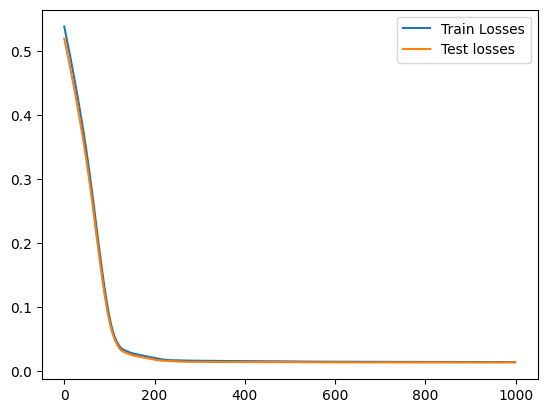

In [101]:
plt.plot(train_losses, label="Train Losses")
plt.plot(test_losses, label="Test losses")
plt.legend()
plt.plot()

In [29]:
# Wrong way to do it

validation_target = Y[-N//2:]
validation_predictions = []

i = 0
while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, -1, 1)
    p = model(input_)[0,0].item() # 1x1 array a escalar
    i += 1

    validation_predictions.append(p)



[]

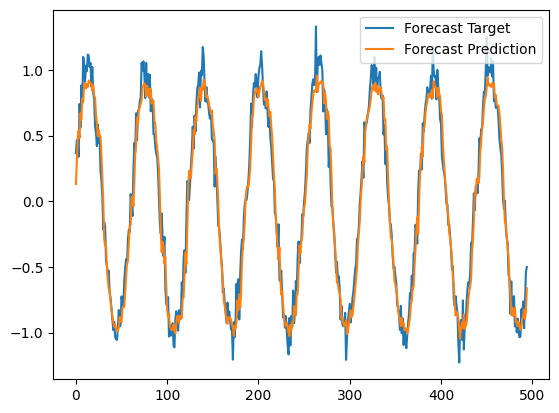

In [30]:
plt.plot(validation_target, label="Forecast Target")
plt.plot(validation_predictions, label="Forecast Prediction")
plt.legend()
plt.plot()

In [102]:

validation_target = Y[-N//2:]
validation_predictions = []

i = 0

x_ =X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = x_.reshape(1, T , 1)
    p = model(input_) # 1x1 array a escalar
    i += 1

    validation_predictions.append(p[0,0].item())
    print(p[0])
    print(x_[1:])
    x_ = torch.cat((x_[1:], p[0]))


tensor([0.2220], grad_fn=<SelectBackward0>)
tensor([-0.5885, -0.4862, -0.4100, -0.4036, -0.4189, -0.1046,  0.0572, -0.0700,
         0.0876])
tensor([0.3142], grad_fn=<SelectBackward0>)
tensor([-0.4862, -0.4100, -0.4036, -0.4189, -0.1046,  0.0572, -0.0700,  0.0876,
         0.2220], grad_fn=<SliceBackward0>)
tensor([0.3987], grad_fn=<SelectBackward0>)
tensor([-0.4100, -0.4036, -0.4189, -0.1046,  0.0572, -0.0700,  0.0876,  0.2220,
         0.3142], grad_fn=<SliceBackward0>)
tensor([0.4928], grad_fn=<SelectBackward0>)
tensor([-0.4036, -0.4189, -0.1046,  0.0572, -0.0700,  0.0876,  0.2220,  0.3142,
         0.3987], grad_fn=<SliceBackward0>)
tensor([0.5572], grad_fn=<SelectBackward0>)
tensor([-0.4189, -0.1046,  0.0572, -0.0700,  0.0876,  0.2220,  0.3142,  0.3987,
         0.4928], grad_fn=<SliceBackward0>)
tensor([0.5961], grad_fn=<SelectBackward0>)
tensor([-0.1046,  0.0572, -0.0700,  0.0876,  0.2220,  0.3142,  0.3987,  0.4928,
         0.5572], grad_fn=<SliceBackward0>)
tensor([0.6294], g

[]

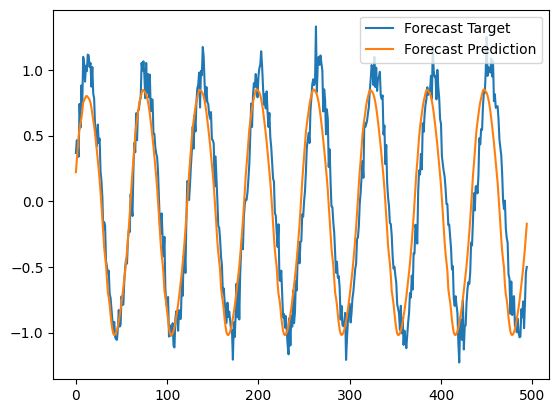

In [103]:
plt.plot(validation_target, label="Forecast Target")
plt.plot(validation_predictions, label="Forecast Prediction")
plt.legend()
plt.plot()